In [334]:
"""
Simple example of using swmm to model a culvert

We are coupling via weir and orifice equation 
(checkout coupling module)

To control oscilations we seem to need small routing_step
set in swmm_input_long_culvert.inp and smoothing of the calculated
Q. At present step to 10secs"""


#------------------------------------------------------------------------------
print('ABOUT to Start Simulation: IMPORT NECESSARY MODULES')
#------------------------------------------------------------------------------

import anuga
import numpy as np
from hymo import SWMMInpFile

#------------------------------------------------------------------------------
print('SETUP FILENAMES, MODEL DOMAIN and VARIABLES')
#------------------------------------------------------------------------------

basename = 'simple_culvert'
outname =  'anuga_swmm_simple_long_culvert'

inp_file = 'swmm_input_long_culvert'
rf = 20  # refinement factor for domain, if too coarse the inlets will overlap the wall
input_Q = 0.0
base_Q  = 0.5
dt = 0.2     # yield step
out_dt = 1.0 # output step

# dt = 2     # yield step
# out_dt = 4.0 # output step
ft = 400     # final timestep
time_average = 1 # sec

verbose   = False
visualise = False



#------------------------------------------------------------------------------
print('SETUP COMPUTATIONAL DOMAIN')
#------------------------------------------------------------------------------

domain = anuga.rectangular_cross_domain(3*rf, rf, len1=60, len2=20)






ABOUT to Start Simulation: IMPORT NECESSARY MODULES
SETUP FILENAMES, MODEL DOMAIN and VARIABLES
SETUP COMPUTATIONAL DOMAIN


/home/anton/miniforge3/envs/anuga_env/lib/python3.8/site-packages/anuga/structures/riverwall.py:124: RuntimeWarning: invalid value encountered in cast
  self.hydraulic_properties_rowIndex=numpy.array([default_int]).astype(int)


In [335]:

domain.set_minimum_storable_height(0.0001) 
domain.set_name(outname) 
print (domain.statistics())


#------------------------------------------------------------------------------
print('SETUP ELEVATION FUNCTION')
#------------------------------------------------------------------------------
def topography(x,y):

    z = 5*np.ones_like(x)

    channel = np.logical_and(y>5,y<15)

    z = np.where(np.logical_and(channel,x<10), x/300, z)
    #z = np.where(np.logical_and(channel,x>20), x/300, z)
    z = np.where(np.logical_and(channel,x>50), x/300, z)
    
    return z

domain.set_quantity('elevation', topography, location='centroids')

#------------------------------------------------------------------------------
print("APPLY MANNING'S ROUGHNESSES")
#------------------------------------------------------------------------------

domain.set_quantity('friction', 0.035)

#------------------------------------------------------------------------------
print('SETUP ANUGA INFLOW Inlet_operator')
#------------------------------------------------------------------------------

line=[[59.0, 5.0],[59.0, 15.0]]
inflow_anuga_inlet_op = anuga.Inlet_operator(domain, line, input_Q)

#------------------------------------------------------------------------------
print('SETUP BOUNDARY CONDITIONS')
#------------------------------------------------------------------------------

print ('Available boundary tags', domain.get_boundary_tags())




------------------------------------------------
Mesh statistics:
  Number of triangles = 4800
  Extent [m]:
    x in [0.00000e+00, 6.00000e+01]
    y in [0.00000e+00, 2.00000e+01]
  Areas [m^2]:
    A in [2.50000e-01, 2.50000e-01]
    number of distinct areas: 4800
    Histogram:
      [2.50000e-01, 2.50000e-01]: 4800
    Percentiles (10 percent):
      480 triangles in [2.50000e-01, 2.50000e-01]
      480 triangles in [2.50000e-01, 2.50000e-01]
      480 triangles in [2.50000e-01, 2.50000e-01]
      480 triangles in [2.50000e-01, 2.50000e-01]
      480 triangles in [2.50000e-01, 2.50000e-01]
      480 triangles in [2.50000e-01, 2.50000e-01]
      480 triangles in [2.50000e-01, 2.50000e-01]
      480 triangles in [2.50000e-01, 2.50000e-01]
      480 triangles in [2.50000e-01, 2.50000e-01]
      480 triangles in [2.50000e-01, 2.50000e-01]
  Boundary:
    Number of boundary segments == 160
    Boundary tags == ['left', 'bottom', 'top', 'right']
------------------------------------------

In [336]:
Br = anuga.Reflective_boundary(domain)
Bd = anuga.Dirichlet_boundary([-1.0,0,0])

Bt = anuga.Transmissive_boundary(domain)

domain.set_boundary({'left': Br, 'bottom': Br, 'top': Br, 'right': Br})


In [337]:
#------------------------------------------------------------------------------
print('SETUP ANUGA Inlet_operators to support coupling with stormwater system')
#------------------------------------------------------------------------------

# inlets across full channel. Make sure to set the culvert in the swmm_simple_long_culvert.inp to a value of 
# cw = 8
# small inlets in centre of channel. Make sure to set the culvert in the swmm_simple_long_culvert.inp to a value of 
#cw = 2.0

cw = 8

inlet_polygon = [[50.0, 10-cw/2], [52.0, 10-cw/2], [52.0, 10+cw/2], [50.0, 10+cw/2]]
inlet1_anuga_region = anuga.Region(domain, polygon=inlet_polygon)

outlet_polygon = [[8.0, 10-cw/2], [10.0, 10-cw/2], [10.0, 10+cw/2], [8.0, 10+cw/2]]
outlet_anuga_region = anuga.Region(domain, polygon=outlet_polygon)

outfall_polygon = [[1.0, 10-cw/2], [2.0, 10-cw/2], [2.0, 10+cw/2], [1.0, 10+cw/2]]
outfall_anuga_region = anuga.Region(domain, polygon=outfall_polygon)

anuga_length_weirs = np.array([2*cw, 2*cw])
anuga_area_manholes = np.array([cw*2, cw*2])


# now setup anuga Inlet_operators to remove or add water from anuga domain.
inlet1_anuga_inlet_op = anuga.Inlet_operator(domain, inlet1_anuga_region, Q=0.0, zero_velocity=False)
outlet_anuga_inlet_op = anuga.Inlet_operator(domain, outlet_anuga_region, Q=0.0, zero_velocity=False)
#outfall_anuga_inlet_op = anuga.Inlet_operator(domain, outfall_anuga_region, Q=0.0, zero_velocity=False)

anuga_beds = np.array([inlet1_anuga_inlet_op.inlet.get_average_elevation(),
                       outlet_anuga_inlet_op.inlet.get_average_elevation()])

print(anuga_beds)


#------------------------------------------------------------------------------
print('SETUP SWMM')
#------------------------------------------------------------------------------

print('Setup swmm simulation')
from pyswmm import Simulation, Nodes, Links
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
sim = Simulation('./swmm_input_long_culvert.inp')
inp = SWMMInpFile('./swmm_input_long_culvert.inp')

sim.start()

swmm_inlet = Nodes(sim)['Inlet']
swmm_outlet = Nodes(sim)['Outlet']
swmm_outfall = Nodes(sim)['Outfall']
swmm_culvert = Links(sim)['Culvert']
swmm_outpipe = Links(sim)['Outpipe']

nodes = [swmm_inlet, swmm_outlet, swmm_outfall]
links = [swmm_culvert, swmm_outpipe]

link_volume_0 = swmm_culvert.volume + swmm_outpipe.volume

#--------------------------------------------------------------------------
print('Setup storage for output')
#--------------------------------------------------------------------------
H_js = []
losses = []

Q_iks =[]
Q_uks =[]
Q_dks =[]
time_series = []
anuga_ws = []
Q_ins = []


from coupling import calculate_Q

#---------------------------------------------------------------------------
print('Average Q calculation')
#---------------------------------------------------------------------------

# Q_in_old = np.array([0.0, base_Q])
Q_in_old = np.array([base_Q, 0.0])



cumulative_inlet_flooding = 0.0
cumulative_outlet_flooding = 0.0
cumulative_inlet_flow = 0.0
cumulative_outlet_flow = 0.0

old_outlet_vol = 0.0
old_inlet_vol = 0.0

plt.style.use('ggplot')
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams.update({'font.size': 10})


SETUP ANUGA Inlet_operators to support coupling with stormwater system
[0.17 0.03]
SETUP SWMM
Setup swmm simulation

 o  Retrieving project dataSetup storage for output
Average Q calculation


In [338]:
print ('Available boundary tags', domain.get_boundary_tags())


Available boundary tags ['left', 'bottom', 'top', 'right']


In [339]:
inp.conduits

,Inlet_Node,Outlet_Node,Length,Manning_N,Inlet_Offset,Outlet_Offset,Init_Flow,Max_Flow
Name,,,,,,,,
Culvert,Inlet,Outlet,51.0,0.013,0,0,0,10
Outpipe,Outlet,Outfall,5.0,0.013,0,0,0,10


In [340]:
correct_vols = []
real_vols = []
boundary_fluxes = []
culvert_volumes = []

In [341]:

#---------------------------------------------------------------------------
print('Start Evolve')
#---------------------------------------------------------------------------
domain.output_frequency = 10
for t in domain.evolve(yieldstep=dt, outputstep=out_dt, finaltime=ft):
    #print('\n')
    print_out = domain.yieldstep_counter%domain.output_frequency == 0
    #print_out = True

    if print_out:
        domain.print_timestepping_statistics()

    anuga_depths = np.array([inlet1_anuga_inlet_op.inlet.get_average_depth(),
                             outlet_anuga_inlet_op.inlet.get_average_depth()])
    
    anuga_stages = np.array([inlet1_anuga_inlet_op.inlet.get_average_stage(),
                             outlet_anuga_inlet_op.inlet.get_average_stage()])


    # Compute the water volumes in the swmm model
    link_volume = swmm_culvert.volume + swmm_outpipe.volume
    node_volume = 0.0
    sewer_volume = link_volume + node_volume
    culvert_volumes.append(swmm_culvert.volume)

    # Compute anuga water volumes and boundary fluxes
    boundary_flux = domain.get_boundary_flux_integral()
    domain_volume = domain.get_water_volume()

    # Calculate correct and real volumes
    total_volume_correct = t*input_Q + t*base_Q +  boundary_flux  + link_volume_0  - Links(sim)['Outpipe'].flow*dt 
    total_volume_real = domain_volume + sewer_volume

    # total_volume_correct = t*input_Q + t*base_Q 
    # total_volume_real = domain_volume + sewer_volume - (boundary_flux  + link_volume_0  - Links(sim)['Outpipe'].flow*dt )
    correct_vols.append(total_volume_correct)
    real_vols.append(total_volume_real)

    boundary_fluxes.append(boundary_flux)
    loss = total_volume_real - total_volume_correct


    # Append data for later plots
    time_series.append(t)
    losses.append(loss)
    anuga_ws.append(anuga_stages.copy())
    

    # setup some aliases
    inlet_head  = swmm_inlet.head
    outlet_head = swmm_outlet.head
    outfall_head = swmm_outfall.head

    inlet_invert = swmm_inlet.invert_elevation
    outlet_invert = swmm_outlet.invert_elevation
    outfall_invert = swmm_outfall.invert_elevation


    if print_out:    
        print('    swmm/anuga time   :', sim.current_time, '/', t)
        print('    Loss              :', loss)
        print('    TV correct        :', total_volume_correct)
        print('    domain volume     :', domain.get_water_volume())
        print('    boundary flux     :', boundary_flux)
        print('    node_volume       :', node_volume)
        print('    sewer_volume      :', sewer_volume)
        print('    anuga_depths      :', anuga_depths)
        print('    anuga_beds        :', anuga_beds)
        print('    anuga_stages      :', anuga_stages)        

        for node in nodes:
            print('   ', node.nodeid,' head         :', node.head)
            print('   ', node.nodeid,' invert elev  :', node.invert_elevation)
            print('   ', node.nodeid,' flooding     :', node.flooding)
            print('   ', node.nodeid,' depth        :', node.depth)
            print('   ', node.nodeid,' volume       :', node.volume)
            print('   ', node.nodeid,' surcharge    :', node.surcharge_depth)
            print('   ', node.nodeid,' lat inflow   :', node.lateral_inflow)
            print('   ', node.nodeid,' tot inflow   :', node.total_inflow)
            print('   ', node.nodeid,' tot outflow  :', node.total_outflow)
            print('   ', node.nodeid,' losses       :', node.losses)
            
        for link in links:
            print('   ', link.linkid,' flow         :', link.flow)
            print('   ', link.linkid,' volume       :', link.volume)



    cumulative_inlet_flooding += swmm_inlet.flooding*dt 
    cumulative_outlet_flooding += swmm_outlet.flooding*dt

    # Calculate the coupling flux and smooth to response
    node_heads = np.array([inlet_head, outlet_head])
    
    # Q_in = calculate_Q(node_heads, anuga_depths, anuga_beds, anuga_length_weirs, anuga_area_manholes)# + np.array([base_Q,0])
    Q_in = calculate_Q(node_heads, anuga_depths, anuga_beds, anuga_length_weirs, anuga_area_manholes, cw=0.6, co=0.6)# + np.array([base_Q,0])

    Q_in = ((time_average - dt)*Q_in_old + dt*Q_in)/time_average
    Q_in_old = Q_in

    Q_ins.append(Q_in.copy())

    if print_out:
        print('    Calculated Q     ', Q_in[0], Q_in[1]) 

    # Run SWMM for a time of dt sewer using the calculated coupling fluxes
    swmm_inlet.generated_inflow(Q_in[0] + base_Q)
    # swmm_inlet.generated_inflow(Q_in[0])
    swmm_outlet.generated_inflow(Q_in[1])
    sim.step_advance(dt)
    sim.next()

    # Determine how much actually flowed into 1D model
    inlet_vol = - swmm_inlet.statistics['lateral_infow_vol'] + swmm_inlet.statistics['flooding_volume'] 
    inlet_flow = (inlet_vol - old_inlet_vol)/dt
    old_inlet_vol = inlet_vol

    if print_out:
        print('    inlet vol   :', inlet_vol)
        print('    inlet flow  :', inlet_flow)

    outlet_vol = - swmm_outlet.statistics['lateral_infow_vol'] + swmm_outlet.statistics['flooding_volume'] 
    outlet_flow = (outlet_vol - old_outlet_vol)/dt
    old_outlet_vol = outlet_vol

    if print_out:
        print('    outlet vol   :', outlet_vol)
        print('    outlet flow  :', outlet_flow)

    cumulative_inlet_flow += inlet_flow*dt
    cumulative_outlet_flow += outlet_flow*dt



    # And consequently set anuga coupling Inlet_operators with actual SWMM fluxes
    inlet1_anuga_inlet_op.set_Q(inlet_flow)
    outlet_anuga_inlet_op.set_Q(outlet_flow + swmm_outfall.total_inflow)


#print(swmm_inlet.statistics)
#print(swmm_outlet.statistics)
#print(swmm_outfall.statistics)



print('Cumulative inlet flooding', cumulative_inlet_flooding)
print('Cumulative outlet flooding', cumulative_outlet_flooding)


print('anuga inlet applied volume ',inlet1_anuga_inlet_op.get_total_applied_volume())
print('anuga inlet cumulative flow', cumulative_inlet_flow)
print('swmm inlet lateral flow', swmm_inlet.statistics['lateral_infow_vol'])
print('swmm inlet flooding vol', swmm_inlet.statistics['flooding_volume'])
print('swmm inlet vol', swmm_inlet.statistics['lateral_infow_vol'] - swmm_inlet.statistics['flooding_volume'])


print('anuga outlet applied volume ',outlet_anuga_inlet_op.get_total_applied_volume())
print('anuga outlet Cumulative flow', cumulative_outlet_flow)
print('swmm outlet lateral flow', swmm_outlet.statistics['lateral_infow_vol'])
print('swmm outlet flooding vol', swmm_outlet.statistics['flooding_volume'])
print('swmm outlet vol', swmm_outlet.statistics['lateral_infow_vol'] - swmm_outlet.statistics['flooding_volume'])

print('anuga inflow applied volume ',inflow_anuga_inlet_op.get_total_applied_volume())



sim.close()

Start Evolve
Time = 0.0000 (sec), steps=0 (1s)
    swmm/anuga time   : 1970-01-01 00:00:00 / 0.0
    Loss              : 0.0
    TV correct        : 0.01554817727427457
    domain volume     : 0.0
    boundary flux     : 0.0
    node_volume       : 0.0
    sewer_volume      : 0.01554817727427457
    anuga_depths      : [0. 0.]
    anuga_beds        : [0.17 0.03]
    anuga_stages      : [0.17 0.03]
    Inlet  head         : 0.07
    Inlet  invert elev  : 0.07
    Inlet  flooding     : 0.0
    Inlet  depth        : 0.0
    Inlet  volume       : 0.0
    Inlet  surcharge    : 0.15
    Inlet  lat inflow   : 0.0
    Inlet  tot inflow   : 0.0
    Inlet  tot outflow  : 0.0
    Inlet  losses       : 0.0
    Outlet  head         : 0.03
    Outlet  invert elev  : 0.03
    Outlet  flooding     : 0.0
    Outlet  depth        : 0.0
    Outlet  volume       : 0.0
    Outlet  surcharge    : 0.15
    Outlet  lat inflow   : 0.0
    Outlet  tot inflow   : 0.0
    Outlet  tot outflow  : 0.0
    Outlet  lo

In [342]:
Q_in

array([-0., -0.])

In [343]:
visualise = True

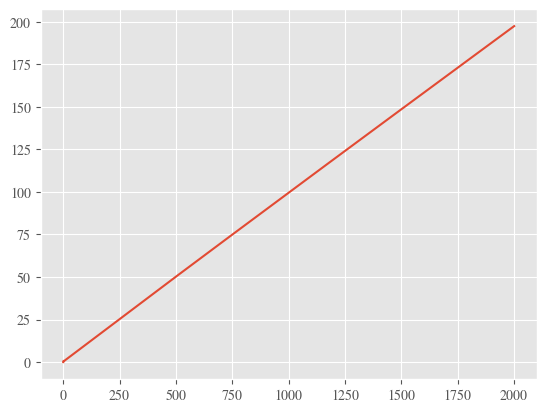

In [345]:
plt.plot(culvert_volumes)

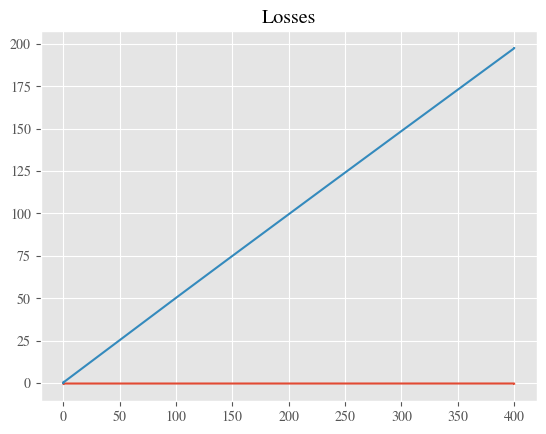

In [347]:
plt.figure(2)
plt.clf()
plt.plot(time_series, -np.array(losses))
plt.plot(time_series,culvert_volumes)
plt.title('Losses')
plt.show()

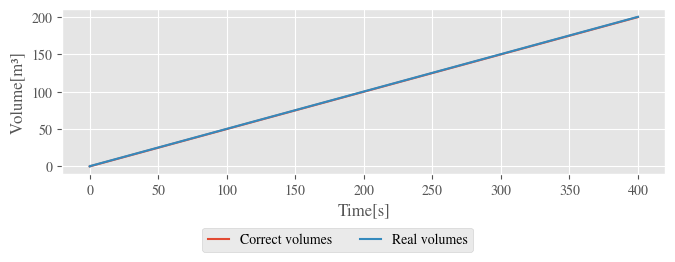

In [348]:


inch = 2.54
fig_size = 17
# fig_size = 34

fig_size = fig_size/inch
fig_aspect = 3
fig, ax = plt.subplots(1,1)
fig.set_size_inches(fig_size, fig_size/fig_aspect, forward=True)


# ax.axvline(65,color = 'k',linestyle = '--')
# ax.plot(time_series,correct_vols,label = 'Correct volumes')
ax.plot(time_series,np.array(correct_vols) + 0.0*np.array(time_series),label = 'Correct volumes')
ax.plot(time_series,real_vols, label = 'Real volumes')
ax.set_xlabel('Time[s]')
ax.set_ylabel('Volume[m³]')



fig.tight_layout(pad = .5)
handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5,-0.15),handlelength=1.5,ncol=5)
if False:
    # plt.savefig(plot_path +'vol_vs_method_' + plotname + '.eps',format = 'eps', bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.savefig('plots/surf_mass_convservation_simple_culvert' + '_tavg_' + str(time_average) + 'input_Q_' + str(input_Q)  + '.eps', bbox_inches='tight')
    plt.savefig('plots/surf_mass_convservation_simple_culvert' + '_tavg_' + str(time_average) + 'input_Q_' + str(input_Q)  + '.png', bbox_inches='tight')

if False:
    # plt.savefig(plot_path +'vol_vs_method_' + plotname + '.eps',format = 'eps', bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.savefig('plots/surf_base_in_inlet_mass_convservation_simple_culvert' + '_tavg_' + str(time_average) + 'base_Q_' + str(base_Q)  + '.eps', bbox_inches='tight')
    plt.savefig('plots/surf_base_in_inlet_mass_convservation_simple_culvert' + '_tavg_' + str(time_average) + 'base_Q_' + str(base_Q)  + '.png', bbox_inches='tight')
